# Importing the neccessary libraries:

In [2]:
import csv
import os
import re
import sys
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier

In [25]:
pip install seaborn

     -------------------------------------- 293.3/293.3 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Getting the Statistics of the Classes present in the dataset:


In [12]:
# Statistics of individual classes
def get_class_statistics(labels, class_statistic=None, class_statistics=None):
    class_statistics = Counter(labels)
    print('\n Class \t\t Number of Instances \n')
    for item in list(class_statistics.keys()):
        print('\t ' + str(item) + '\t\t\t ' + str(class_statistics[item]))

path = 'training_data_resampled.csv'


 `get_class_statistics` function calculates and prints the distribution of instances across different classes in the dataset. This information is crucial for understanding the balance or imbalance in the class distribution
 
 labels: This is the array or series containing the class labels of the instances in the dataset.

class_statistics: This variable is initialized as None in the function parameters, and it is later assigned the result of Counter(labels). The Counter is a Python class that counts the occurrences of elements in a collection (in this case, the class labels).

The function then prints a header for the statistics table.

# Loading the Dataset:

In [13]:
# Load the file using Pandas
reader = pd.read_csv(path)

data = reader.iloc[:, :-1]
labels = reader['target']

get_class_statistics(labels)
input('\n \t Press enter to move forward   \n')


 Class 		 Number of Instances 

	 0			 192333
	 2			 31811
	 1			 4168

 	 Press enter to move forward   



''

# Data Visualization:

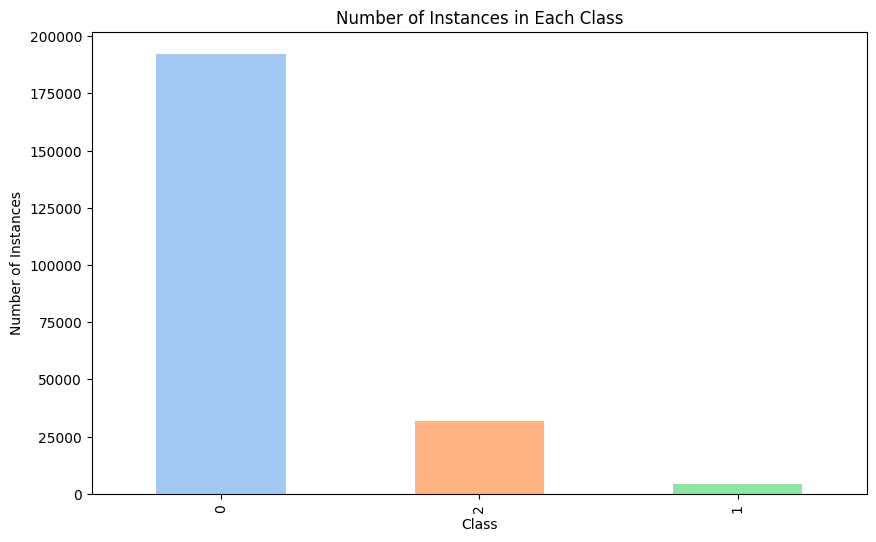

In [26]:
# Visualize the number of instances in each class
import matplotlib.pyplot as plt
import seaborn as sns
class_counts = labels.value_counts()

# Data Visualization - Bar plot with color
plt.figure(figsize=(10, 6))
colors = sns.color_palette('pastel')  # Use seaborn color palette
class_counts.plot(kind='bar', color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances in Each Class')
plt.show()


# Train Test Split in the Data: 

In [27]:
# Training and test split WITH stratification
training_data, validation_data, training_cat, validation_cat = train_test_split(data, labels,test_size=0.2, random_state=42, stratify=labels)

test_size=0.2: This parameter determines the size of the validation set. In this case, it's set to 20%, meaning 20% of the data will be used for validation, and the remaining 80% will be used for training.

random_state=42: This parameter sets the random seed for reproducibility. Setting a random seed ensures that every time we run the code, the same random split will be generated. The specific value (42 in this case) is somewhat arbitrary; we could use any integer.

stratify=labels: This parameter enables stratified sampling. Stratified sampling ensures that the distribution of class labels in the original dataset is maintained in both the training and validation sets. This is particularly useful when dealing with imbalanced datasets, where some classes have significantly fewer samples than others.

# Feature Selection

In [38]:
# Feature Selection: SelectKBest
selector = SelectKBest(chi2, k=10)  # Adjust the value of k as needed
training_data_selected = selector.fit_transform(training_data, training_cat)
validation_data_selected = selector.transform(validation_data)

# Getting the selected features
features = training_data.columns[selector.get_support()]

# Feature Selection: Correlation
correlation_matrix = training_data.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
training_data_corr_removed = training_data.drop(to_drop, axis=1)
validation_data_corr_removed = validation_data.drop(to_drop, axis=1)

# Print selected features for each method
print('\n Selected Features - SelectKBest:')
print(training_data.columns[selector.get_support()])

print('\n Selected Features - Correlation Removed:')
print(training_data_corr_removed.columns)



 Selected Features - SelectKBest:
Index(['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Income'],
      dtype='object')

 Selected Features - Correlation Removed:
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


SelectKBest is a method for univariate feature selection. It selects the top k features based on univariate statistical tests, and chi2 (chi-squared) is the specific statistical test used here.

k=10: This parameter specifies that the algorithm should select the top 10 features.

training_data_selected: This variable stores the transformed training data with only the selected features.

validation_data_selected: This variable stores the transformed validation data using the same set of selected features.

correlation_matrix: This variable holds the correlation matrix computed from the training data.

np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool): This creates an upper triangular matrix with boolean values, masking the lower triangle. This is done to avoid redundant calculations since the correlation matrix is symmetric.

to_drop: This list contains the names of features that are highly correlated (correlation coefficient > 0.9) with at least one other feature.

training_data_corr_removed: This variable stores the training data with highly correlated features removed.

validation_data_corr_removed: This variable stores the validation data with the same set of correlated features removed.

# Over Sampling:

In [29]:
# Statistics before oversampling
print('\n Training Data Before Oversampling ')
get_class_statistics(training_cat)

# Oversampling using RandomOverSampler
ros = RandomOverSampler(random_state=42)
training_data_resampled, training_cat_resampled = ros.fit_resample(training_data, training_cat)

# Statistics after oversampling
print('\n Training Data After Oversampling ')
get_class_statistics(training_cat_resampled)
input('\n \t Press enter to move forward   \n')

print('\n Training Data ')
training_cat = [str(x) for x in training_cat]
get_class_statistics(training_cat)
input('\n \t Press enter to move forward   \n')

print('\n Validation Data ')
validation_cat = [str(x) for x in validation_cat]
get_class_statistics(validation_cat)
input('\n \t Press enter to move forward   \n')


 Training Data Before Oversampling 

 Class 		 Number of Instances 

	 0			 153866
	 1			 3334
	 2			 25449

 Training Data After Oversampling 

 Class 		 Number of Instances 

	 0			 153866
	 1			 153866
	 2			 153866

 	 Press enter to move forward   


 Training Data 

 Class 		 Number of Instances 

	 0			 153866
	 1			 3334
	 2			 25449

 	 Press enter to move forward   


 Validation Data 

 Class 		 Number of Instances 

	 2			 6362
	 0			 38467
	 1			 834

 	 Press enter to move forward   



''

# Visualization after oversampling:

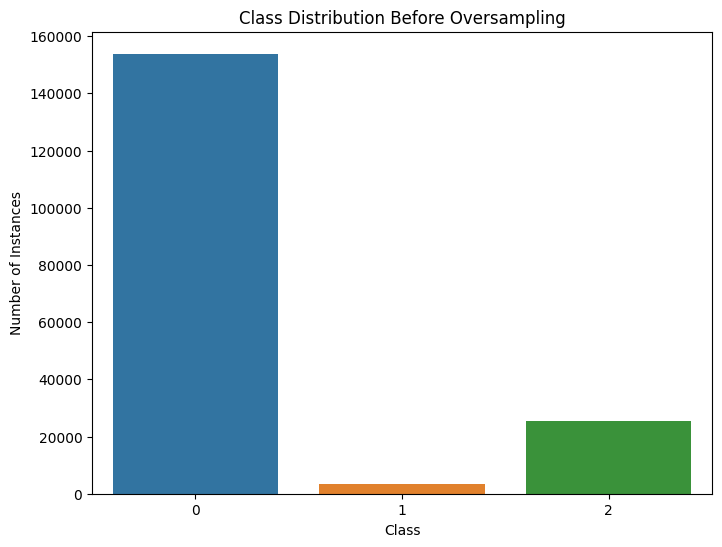

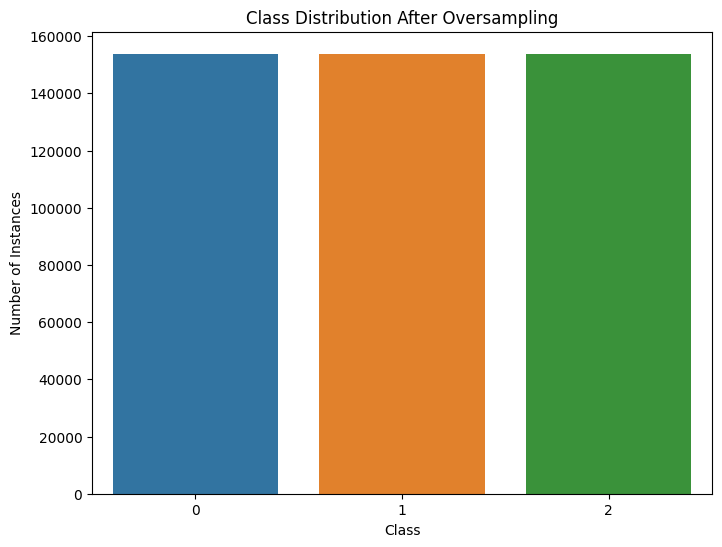

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize class distribution
def visualize_class_distribution(labels, title):
    class_counts = Counter(labels)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    sns.barplot(x=classes, y=counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.show()

# Visualizing class distribution before oversampling
visualize_class_distribution(training_cat, 'Class Distribution Before Oversampling')

# Visualizing class distribution after oversampling
visualize_class_distribution(training_cat_resampled, 'Class Distribution After Oversampling')


Oversampling with RandomOverSampler: The RandomOverSampler is initialized with a random state for reproducibility. It takes the training data (training_data) and corresponding labels (training_cat) as input and oversamples the minority class (the class with fewer instances) to match the majority class.

# Classification Models:

# Logistic Classification, Random Forest, MNB, DecisionTreeClassifier, AdaBoost Classifier:


In [31]:
# Classification
clf1 = LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l2', max_iter=1000)

clf2 = RandomForestClassifier(n_estimators=100, max_features=None, class_weight='balanced')

clf3 = MultinomialNB(
    alpha=1.0,  # Additive (Laplace/Lidstone) smoothing parameter
    fit_prior=True,  
    class_prior=None  
)

clf4 = DecisionTreeClassifier(
    criterion='gini',  # slecting Split criterion ('gini')
    max_depth=None,  # Maximum depth of the tree. None means unlimited depth.
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1  # Minimum number of samples required to be at a leaf node
)

clf5 = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    algorithm='SAMME.R',
    random_state=42
)


classifiers = [clf1, clf2, clf3, clf4, clf5]
classifier_names = ['Logistic Regression', 'Random Forest', 'Multinomial Naive Bayes',
                    'Decision Tree', 'AdaBoost']

Logistic Regression (clf1):

Solver: Algorithm to use for optimization. 'liblinear' is suitable for small datasets.
Class Weight: 'balanced' adjusts weights inversely proportional to class frequencies.
Penalty: Regularization term ('l2' for Ridge regression).
Max Iterations: Maximum number of iterations for the solver to converge.

Random Forest (clf2):

Number of Estimators: The number of trees in the forest (100 in this case).
Max Features: The maximum number of features considered for splitting a node (None means all features).
Class Weight: 'balanced' adjusts weights to account for class imbalance.

Multinomial Naive Bayes (clf3):

Alpha: Additive smoothing parameter (Laplace/Lidstone) to avoid zero probabilities.
Fit Prior: Whether to learn class prior probabilities or not.
Class Prior: Prior probabilities of the classes. If specified, the priors are not adjusted based on data.

Decision Tree (clf4):

Criterion: Split criterion ('gini' or 'entropy').
Max Depth: Maximum depth of the tree. None means unlimited depth.
Min Samples Split: Minimum number of samples required to split an internal node.
Min Samples Leaf: Minimum number of samples required to be at a leaf node.

AdaBoost (clf5):

Base Estimator: The base estimator from which the boosted ensemble is built (Decision Tree with max depth 1).
Number of Estimators: The maximum number of estimators at which boosting is terminated.
Algorithm: The boosting algorithm ('SAMME.R' is for real-valued data).
Random State: Seed for reproducibility.

# Hyperparametric Tuning: GridSearchCV AND Fitting the Model , along with the Classification Report of Each Model:

In [36]:
# Hyperparameter tuning using GridSearchCV
for clf, clf_name in zip(classifiers, classifier_names):
    # Define the pipeline with SelectKBest for feature selection
    pipeline = Pipeline([
        ('selector', SelectKBest(chi2)),
        ('classifier', clf),
    ])

    # Defining the parameters for hyperparameter tuning
    parameters = {
        'selector__k': [5, 10, 15],  # Adjust as needed
        # Add classifier-specific hyperparameters here
    }

    # Using StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Creating GridSearchCV instance
    grid_search = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=skf)

    # Fitting the model
    grid_search.fit(training_data, training_cat)

    # Printing classifiers name
    print(f'\n##### {clf_name} #####\n')

    # Printing best parameters from the grid search
    print('Best Parameters:', grid_search.best_params_)

    # Getting the best classifier from the grid search
    best_clf = grid_search.best_estimator_

    # Evaluation on the validation set
    predicted = best_clf.predict(validation_data)
    class_names = [str(item) for item in list(Counter(validation_cat).keys())]

    # Classification report of the classifiers:
    print('##### Classification Report #####\n')
    print(classification_report(validation_cat, predicted, target_names=class_names))

    print('Confusion Matrix:')
    print(confusion_matrix(validation_cat, predicted))

    # Printing precision, recall, and f1-score
    pr = precision_score(validation_cat, predicted, average='macro')
    rl = recall_score(validation_cat, predicted, average='macro')
    fm = f1_score(validation_cat, predicted, average='macro')
    print(pr)
    print(rl)
    print(fm)


##### Logistic Regression #####

Best Parameters: {'selector__k': 15}
##### Classification Report #####

              precision    recall  f1-score   support

           2       0.90      0.89      0.89     38467
           0       0.10      0.01      0.01       834
           1       0.41      0.50      0.45      6362

    accuracy                           0.82     45663
   macro avg       0.47      0.46      0.45     45663
weighted avg       0.82      0.82      0.82     45663

Confusion Matrix:
[[34164    36  4267]
 [  571     5   258]
 [ 3168     9  3185]]
0.47148444172331994
0.4649206071200469
0.4528936868017417

##### Random Forest #####

Best Parameters: {'selector__k': 10}
##### Classification Report #####

              precision    recall  f1-score   support

           2       0.87      0.88      0.87     38467
           0       0.02      0.04      0.03       834
           1       0.33      0.26      0.29      6362

    accuracy                           0.78     45663
 

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           2       0.87      0.97      0.92     38467
           0       0.00      0.00      0.00       834
           1       0.55      0.21      0.31      6362

    accuracy                           0.85     45663
   macro avg       0.47      0.40      0.41     45663
weighted avg       0.81      0.85      0.82     45663

Confusion Matrix:
[[37434     0  1033]
 [  753     0    81]
 [ 4998     0  1364]]


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4724242221207387
0.3958479337828611
0.4085043253497036


The hyperparameters to be tuned are specified in the parameters dictionary. In this case, it includes the hyperparameter for feature selection (selector__k) with three values: 5, 10, and 15.

# Getting the Best Classifier Report:

In [37]:
best_classifier = None
best_score = 0  # Assuming higher score is better (e.g., F1-score)

for clf, clf_name in zip(classifiers, classifier_names):
    pipeline = Pipeline([
        ('selector', SelectKBest(chi2)),
        ('classifier', clf),
    ])
    
    parameters = {
        'selector__k': [5, 10, 15],  
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=skf)
    grid_search.fit(training_data, training_cat)

    # Retrieving the best classifier and its score
    current_score = grid_search.best_score_
    if current_score > best_score:
        best_score = current_score
        best_classifier = grid_search.best_estimator_

    

# Displaying the best classifier and its results
print('\n##### Best Classifier #####\n')
print('Best Parameters:', best_classifier.named_steps['classifier'].get_params())
predicted_best = best_classifier.predict(validation_data)
class_names_best = [str(item) for item in list(Counter(validation_cat).keys())]

print('##### Classification Report #####\n')
print(classification_report(validation_cat, predicted_best, target_names=class_names_best))

print('Confusion Matrix:')
print(confusion_matrix(validation_cat, predicted_best))

# Printing precision, recall, and f1-score
pr_best = precision_score(validation_cat, predicted_best, average='macro')
rl_best = recall_score(validation_cat, predicted_best, average='macro')
fm_best = f1_score(validation_cat, predicted_best, average='macro')
print(pr_best)
print(rl_best)
print(fm_best)



##### Best Classifier #####

Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
##### Classification Report #####

              precision    recall  f1-score   support

           2       0.90      0.89      0.89     38467
           0       0.10      0.01      0.01       834
           1       0.41      0.50      0.45      6362

    accuracy                           0.82     45663
   macro avg       0.47      0.46      0.45     45663
weighted avg       0.82      0.82      0.82     45663

Confusion Matrix:
[[34164    36  4267]
 [  571     5   258]
 [ 3168     9  3185]]
0.47148444172331994
0.4649206071200469
0.4528936868017417


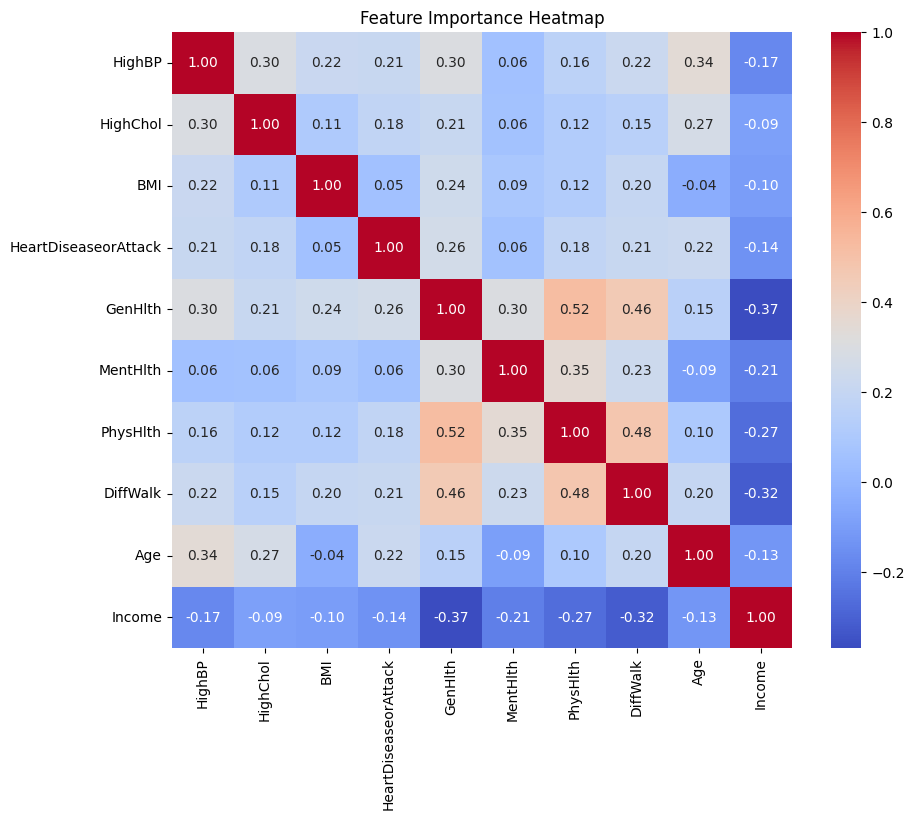

In [39]:
# Feature Importance Heatmap (for classifiers without feature_importances_ attribute)
if not hasattr(best_classifier.named_steps['classifier'], 'feature_importances_'):
    # Convert NumPy array to DataFrame
    training_data_selected_df = pd.DataFrame(training_data_selected, columns=features)

    # Calculate correlation matrix
    correlation_matrix_features = training_data_selected_df.corr()

    # Plot Heatmap
    plt.figure(figsize=(10, 8))
    plt.title("Feature Importance Heatmap")
    sns.heatmap(correlation_matrix_features, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()